In [1054]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import os
from sklearn.externals import joblib


In [1055]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [1056]:
def preprocessing(image):
    
    #RGB to Gray scale conversion
    img_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    #Noise removal with iterative bilateral filter(removes noise while preserving edges)
    noise_removal = cv2.bilateralFilter(img_gray,9,75,75)

    #Histogram equalisation for better contrast in image and equal distribution of pixels
    equal_histogram = cv2.equalizeHist(noise_removal)

    #Morphological opening with a rectangular structure element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=15)

    #Image subtraction(Subtracting the Morphed image from the histogram equalised Image)
    sub_morp_image = cv2.subtract(equal_histogram,morph_image)

    #Thresholding the image
    ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)
    
    return thresh_image

In [1057]:
#Image Pre-processing

def find_contours(image,prepro):
    
    im = image.copy()

    if prepro == 0:

        imgBlurred = cv2.GaussianBlur(im, (5,5), 0)

        gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)
        # plt.imshow(gray)
        # plt.show()

        # sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)
        # # plt.imshow(sobelx)

        # sobely = cv2.Sobel(gray,cv2.CV_8U,0,1,ksize=3)

        # ret,thresh = cv2.threshold(imgray,127,255,0)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,6)
#         plt.imshow(thresh)
#         plt.show()

    else:

        thresh = preprocessing(im)
#         plt.imshow(thresh)
#         plt.show()


    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    image_area = im.shape[0]*im.shape[1]

    plate_like_objects=[]
    dims=[]
    for i,cnt in enumerate(contours) :

        area = cv2.contourArea(cnt)

        if(area > 0.01*image_area):
            x,y,w,h = cv2.boundingRect(cnt)
            img = cv2.rectangle(im.copy(),(x,y),(x+w,y+h),(0,255,0),2)
#             plt.imshow(img)
#             plt.show()

            plate = img[y:y+h,x:x+w]
            dims.append([x,y,w,h])
            plate_like_objects.append(plate)
            
    return plate_like_objects,dims


In [1102]:
#Detection

def plate_detection(plate_like_objects):
    
    number_plate = 999
    min_plate_area = image_area

    for i in range(len(plate_like_objects)):

        image = plate_like_objects[i]

        img = np.int16(image)  

        contrast   = 90
        brightness = 50

        img = img*(contrast/127 + 1) - contrast + brightness

        # we now have an image that has been adjusted for brightness and
        # contrast, but we need to clip values not in the range 0 to 255
        img = np.clip(img, 0, 255)  # force all values to be between 0 and 255

        # finally, convert image back to unsigned 8 bit integer
        img = np.uint8(img)

        plate_area = img.shape[0]*img.shape[1]

        imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        thresh = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,7)

        license_plate = np.invert(thresh)

        labelled_plate = measure.label(license_plate)

        character_dimensions = (0.2*license_plate.shape[0], 0.68*license_plate.shape[0], 0.02*license_plate.shape[1], 0.40*license_plate.shape[1])
        min_height, max_height, min_width, max_width = character_dimensions

        characters = []
        max_char = 5

        for regions in regionprops(labelled_plate):
            y0, x0, y1, x1 = regions.bbox
            region_height = y1 - y0
            region_width = x1 - x0

            if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:

                roi = license_plate[y0:y1, x0:x1]

                resized_char = resize(roi, (20, 20))
                characters.append(resized_char)

        if len(characters)>max_char and plate_area <= min_plate_area :

    #         if plate_area <= min_plate_area:

            min_plate_area = plate_area
            number_plate = i
            
    return number_plate


In [1103]:
#Segmentation
def Segmentation(number_plate):

    x,y,w,h = dims[number_plate]
    
    image = im[y:y+h,x:x+w]
  
    img = np.int16(image)  

    contrast   = 90
    brightness = 50

    img = img*(contrast/127 + 1) - contrast + brightness

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
  
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,7)
    
    thresh = cv2.copyMakeBorder(thresh,5,5,5,5,cv2.BORDER_CONSTANT)

    license_plate = np.invert(thresh)
    
    labelled_plate = measure.label(license_plate)
    
    character_dimensions = (0.2*license_plate.shape[0], 0.68*license_plate.shape[0], 0.01*license_plate.shape[1], 0.40*license_plate.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions
   
    fig, ax1 = plt.subplots(1)
    ax1.imshow(license_plate, cmap="gray")

    number_plate_char = []
    column_list_x = []
    column_list_y = []
    
    for regions in regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0       

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            roi = license_plate[y0:y1, x0:x1]
                       
            # draw a red bordered rectangle over the character.
            rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                           linewidth=2, fill=False)
                        
            ax1.add_patch(rect_border)
            
            resized_char = resize(roi, (20, 20))
            number_plate_char.append(resized_char)
            
            # this is just to keep track of the arrangement of the characters
            column_list_x.append(x0)
            column_list_y.append(y0)
            
    fig.savefig("Output/segmented_img.jpg")

    return number_plate_char,column_list_x,column_list_y



In [1104]:
#Recognition
def Recognition(number_plate_char,column_list_x,column_list_y,model,model_dir,current_dir):
    
    classification_result = []

    for each_character in number_plate_char:
        # converts it to a 1D array
        each_character = each_character.reshape(1, -1);
        result = model.predict(each_character)
        classification_result.append(result)

    plate_string = ''
    for eachPredict in classification_result:
        plate_string += eachPredict[0]

    # it's possible the characters are wrongly arranged
    # since that's a possibility, the column_list will be
    # used to sort the letters in the right order

    column_list_y = [int(x > min(column_list_y)+10) for x in column_list_y]
    column_list_copy = column_list_x[:]

    zipped_pairs = zip(column_list_y, column_list_x)
    column_list = [x for _, x in sorted(zipped_pairs)]

    # column_list_copy = column_list[:]
    # column_list = sorted(column_list, key=lambda x: x[1])
    rightplate_string = ''
    for each in column_list:
        rightplate_string += plate_string[column_list_copy.index(each)]
        
    return rightplate_string


/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


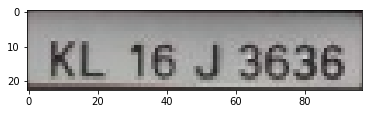

KL10J3636


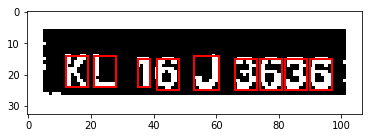

In [1106]:
#Main Function

current_dir = os.path.dirname(os.path.realpath('__file__'))
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

im = cv2.imread('Data/63.jpg')
im = image_resize(image=im,height= 280)

image = im.copy()

plate_like_objects,dims = find_contours(image,prepro=0)
number_plate = plate_detection(plate_like_objects)

#Detected Number Plate
if number_plate == 999:
    plate_like_objects,dims = find_contours(image,prepro=1)
    number_plate = plate_detection(plate_like_objects)
    
if number_plate !=999:
    
    x,y,w,h = dims[number_plate]    
    number_plate_img = im[y:y+h,x:x+w]
    plt.imshow(number_plate_img)
    plt.show()

    number_plate_char,column_list_x,column_list_y = Segmentation(number_plate= number_plate)

    plate_string = Recognition(number_plate_char,column_list_x,column_list_y,model,model_dir,current_dir)

    print(plate_string)
else:
    print("No plate detected")
